#### Example: breaking down PRI-T

Here we'll look into how PRI-T is defined.

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import re

#### Hidden states

PRI-T is a Hidden Markov Model (HMM), which means it describes the relationship between some hidden, discrete state $H_{t}$ to a set of observations $O_{t}$ at each timestep *t*. In our case, we're trying to infer target positions (our $H_i$), which we don't know, from our observed cursor behavior (our $O_i$).


This HMM uses a simple assumption: the cursor behavior at a given timestep is only directly dependent on the current target state. This simple statement results in a very powerful tool for modeling timeseries. Given a set of observations $\{O_1, ..., O_L\}$, we can solve for the most likely sequence of hidden states across time via a nice shortcut:

$$P(H_1, ..., H_L | O_1, ..., O_L) \propto P(H_1) \prod_{i=2}^{L} P(H_{i} | H_{i-1}) \prod_{i=1}^{L} P(O_i | H_i)$$

If each of the probabilities on the right hand side is defined, we can then evaluate the probabilities of different possible target sequences and then pick the most likely. Reinterpreting through the lens of our problem:
- $P(H_1)$ is a vector of *prior probabilities* of the target states. It reflects our beliefs about the target position without having observed any data yet.
- $P(H_{i} | H_{i-1})$ describes how the target state evolves across time. 
- $P(O_{i} | H_{i})$ is our observation model: it tells us what our cursor behavior should look like for a given target.

Below we'll break down each of these in turn. Let's start with how we even define the target state.

#### Defining the target state

Since we're interested in the target position (which we're trying to infer without groundtruth), we'll let the target state simply be the X and Y coordinates of the target at a given timestep.

HMMs need the state to be discrete, but target positions are continuous! At least up to pixel resolutions. To acocunt for this, we'll discretize the screen into a bunch of small squares.

In [2]:
from PRIT.prit_utils import generateTargetGrid, generateTransitionMatrix
from PRIT.prit import HMMRecalibration

gridSize  = 20      # number of rows/columns when discretizing screen
stayProb  = 0.999  # probability that target just stays where it is at any given timestep


nStates                 = gridSize**2
targLocs                = generateTargetGrid(gridSize = gridSize, is_simulated=True)
stateTrans, pStateStart = generateTransitionMatrix(gridSize = gridSize, stayProb = stayProb)

Text(0, 0.5, 'Y coordinate')

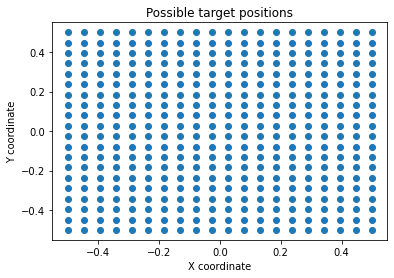

In [10]:
plt.scatter(targLocs[:, 0], targLocs[:, 1])
plt.title('Possible target positions')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

Here we've discretized the screen into a `gridSize x gridSize` grid of possible positions. So the target can be at the center (blue dots) of any of these possible locations. 

Since we don't know much about whatever the user is doing (maybe they're typing on a keyboard, maybe they're clicking buttons, etc.), we won't assume anything about the overall distribution of target states. We'll do this by setting our vector of **prior probabilities** to have *equal weighting across all possible states*.

In [36]:
print('Sum of state priors:', np.sum(pStateStart))
print('State likelihoods:', np.unique(pStateStart))

Sum of state priors: 0.9999999999999998
State likelihoods: [0.0025]


#### Defining target evolution

We now have a way of defining target states (just the position) and our prior belief in its location (basically, no idea). Next we need to describe how the target evolves across time, which is the term $P(H_{i} | H_{i-1})$ from earlier.

Like before, we'll basically assume nothing about the target except:
-  it has a high likelihood of staying in its current position at any given timestep. It takes humans/monkeys on the order of ~1 second to reach new positions when going fast, but our timesteps are ~10-50 milliseconds. So in practice the target is jumping around every timestep but rather just comfortably chilling.

- the target has an equal likelihood of moving to any new position. Here we're again saying that we don't know anything about the task.

We'll capture these two beliefs with a *transition matrix* (`stateTrans`), which is a `gridSize x gridSize` matrix where entry (i, j) captures the probability of the target moving from state j to state i:

$T_{i,j} := P(H_{t} = h_j | H_{t-1} = h_i)$

The diagonal will have very large values, as these entries correspond to the probability of the target staying where it is. The off-diagonals will have small, uniform values as we're not assuming anything about how the target moves. Let's visualize it below:

Text(0.5, 1.0, 'State transition matrix')

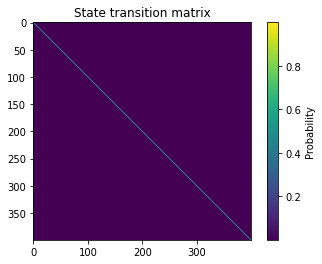

In [41]:
plt.imshow(stateTrans)
plt.colorbar(label = 'Probability')
plt.title('State transition matrix')

#### Observation model: the secret sauce

We now have a description of how the target moves across the screen with time. But during BCI free use, we don't actually have these values anywhere. We instead get access to the cursor behavior, $O_t$, which is composed of two subpieces:
- the cursor position $p_t$
- the cursor velocity $v_t$

To complete the factorization from earlier, we need to link these observations to our target state $H_t$. We'll do this by considering the *angle* of the cursor velocity with respect to each possible target position. If the cursor is heading toward a target, it should on average point toward the target (with some deviation).

We'll model this with a *Von Mises distribution*, which is kinda like a Gaussian for circular statistics and parametrized by a mean direction $\mu$ and dispersion $\kappa$. We'll set `\mu = 0` since we're assuming the cursor velocity angle points toward the target on average. 

Below are some example Von Mises distributions with different $\kappa$ values:

Text(0, 0.5, 'Unnormalized prob')

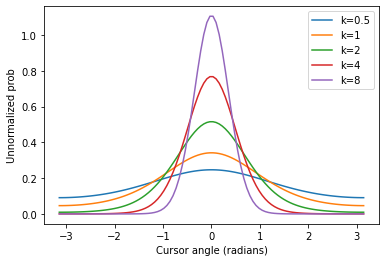

In [61]:
import scipy

x_vals = np.linspace(-np.pi, np.pi, 100)

vm_pdf = lambda x, kappa: np.exp((kappa * np.cos(x).T) - np.log(2*np.pi* scipy.special.i0(kappa)))

for k in [0.5, 1, 2, 4, 8]:
    plt.plot(x_vals, vm_pdf(x_vals, k), label = 'k='+str(k))
plt.legend()
plt.xlabel('Cursor angle (radians)')
plt.ylabel('Unnormalized prob')

We'll complicate this a tad further: when cursors are close to a velocity, there tend to be much larger angular errors. 

We use a weighting function to adjust the concentration parameter $\kappa$ in turn based on its distance to the target. There are plenty of reasonable options but we chose a logistic function.

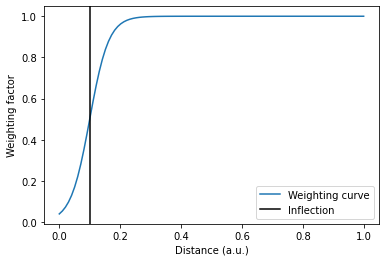

In [70]:
logistic_inflection = 0.1
logistic_exponent   = 32 

adjustKappa = lambda x: 1 / (1 + np.exp(-1 * (x - 0.1) * logistic_exponent))

dists = np.linspace(0, 1, 100)
plt.plot(dists, adjustKappa(dists), label = 'Weighting curve')
plt.xlabel('Distance (a.u.)')
plt.ylabel('Weighting factor')
plt.axvline(logistic_inflection, c = 'k', label = 'Inflection')
plt.legend()

To adjust $\kappa$, we simply multiply it with the weighting factor. Timesteps near the target have a smaller weighting factor, so the final $\kappa$ term is also smaller. Our revised observation model is then:

$P(O_t | H_t) = VonMises(\angle(v_t, H_t - p_t); 0, f(\kappa, ||p_t - H_t||)$

where $\angle(v_t, H_t - p_t)$ is the angle between the current cursor velocity $v_t$ and the point-at-target vector. Below we'll fix our base $\kappa$ value but modify the effective value using the distance from the target - let's see how the probability distribution changes.

Text(0.5, 1.0, 'Fixed base kappa = 2')

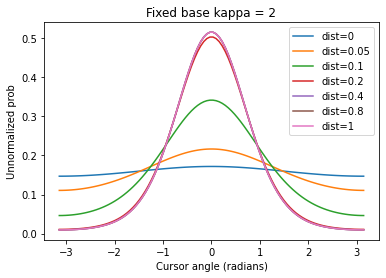

In [76]:
kappa  = 2
x_vals = np.linspace(-np.pi, np.pi, 100)

for dist in [0, 0.05, 0.1, 0.2, 0.4, 0.8, 1]:
    new_kappa = adjustKappa(dist) * kappa    
    plt.plot(x_vals, vm_pdf(x_vals, new_kappa), label = 'dist='+str(dist))
    
plt.legend()
plt.xlabel('Cursor angle (radians)')
plt.ylabel('Unnormalized prob')
plt.title(f'Fixed base kappa = {kappa}')

So in review we have a couple of hyperparameters when building PRI-T:
    
- `gridSize`: how finely we discretize the screen (values >= 20 are fine)
- `stayProb`: how likely the target is to stay at given position (0.99 - 0.9999 generally good)
- `vmKappa` : concentration parameter for observation model (2 - 8 usually good; this is maybe the most important to tune)
- `logistic_inflection` : inflection point for kappa weighting function (maybe ~10% of screen width is fine)
- `logistic_exponent` : slope of logistic curve (20-40 seems okay...?? least confident about this one)

Okay, so we have all the bits and pieces for that probability $P(H_1, ..., H_n | O_1, ... O_n)$ defined. But how do we actually *find* the most likely sequence out of all the possible target sequences that could exist? This involves a fast (linear time!) algorithm called a ["Viterbi search"](https://en.wikipedia.org/wiki/Viterbi_algorithm). Using the Viterbi search, we can obtain the the most likely sequence of targets across time ("Viterbi sequence"). We can separately get the probabilities of the target being in a given position at all timesteps ("occupation probabilities").

By feeding retrospective cursor information into PRI-T, we can hence get inferred target positions and use that to retrain our decoder.

### Optional: adding click

If we have user clicks, we can integrate those as well. We do this by providing a function $f$ that maps distances to the interval $[0, 1]$. This function should take in a distance and return a fraction that specifices the likelihood of a click being issued at that distance, i.e. for some possible target $h_i$ that is $x$ units away from the cursor:

$ P(click | H_t = h_i) \sim Bernoulli(f(x))$

This function should basically just say "clicks are more likely when you're over the target". Here's a simple example below:

Text(0, 0.5, 'P(click | distance)')

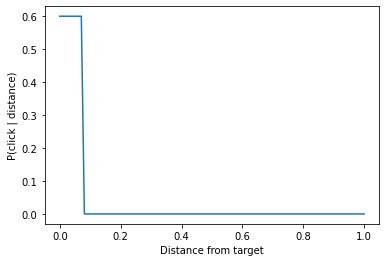

In [80]:
p = 0.6
getClickProb = lambda x: p * (x < 0.075).astype(int) # target radius in simulator is 0.075


dists = np.linspace(0, 1, 100)
plt.plot(dists, getClickProb(dists))
plt.xlabel('Distance from target')
plt.ylabel('P(click | distance)')

Since we know the target sizes in our simulator, we use a very simple model: the click has some probability $p$ of being issued when over the target and 0 otherwise. If you don't know the target sizes beforehand, you can also try using a logistic function like earlier.